# Practical Session on Graph Neural Networks

**by Matthieu Nastorg**

## **PART 1 : CODING** (8/20)

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/ 
#####################################################
import torch 

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 18.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 16.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 5.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.7/874.7 KB 3.9 

### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it : 

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [2]:
!pip install python-igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.0 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.10.4-py3-none-any.whl size=9076 sha256=ef9d93a1eeeb877a641291d679f3d06a113e33425a406acf396df7b7ef7d856b
  Stored in directory: /root/.cache/pip/wheels/dc/07/ac/bff79052fd6222d1239b228cd24a47222f227c2350f9c4df01
Successfully built python-igraph


In [3]:
!apt -qq install libcairo2-dev 
!pip install pycairo --quiet

The following additional packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libffi-dev libglib2.0-dev
  libglib2.0-dev-bin liblzo2-2 libmount-dev libpixman-1-dev libselinux1-dev
  libsepol1-dev libxcb-render0-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc libgdk-pixbuf2.0-bin
  | libgdk-pixbuf2.0-dev libxml2-utils
The following NEW packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libcairo2-dev libffi-dev
  libglib2.0-dev libglib2.0-dev-bin liblzo2-2 libmount-dev libpixman-1-dev
  libselinux1-dev libsepol1-dev libxcb-render0-dev libxcb-shm0-dev
0 upgraded, 13 newly installed, 0 to remove and 22 not upgraded.
Need to get 3,492 kB of archives.
After this operation, 20.0 MB of additional disk space will be used.
Selecting previously unselected package liblzo2-2:amd64.
(Reading database ... 128275 files and directories currently installed.)
Preparing to unpack .../00-liblzo2-2_2.10-2_amd64.deb ...
Unp

In [4]:
!pip install hiddenlayer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from torch_geometric.nn import GraphConv, GATConv
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

import networkx as nx
from networkx.readwrite import json_graph
import igraph as ig

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training 
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct node's labels**.

**It is a node (multi-level) classification task** (trained using supervised learning). 

For your curiosity, more details information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [6]:
### LOAD DATASETS

DATASET_NUMBER = 0
BATCH_SIZE = 2

# Train Dataset
train_dataset = PPI(root="", split='train')
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split='val')
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split='test')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# IMPORTANT VARIABLES
n_nodes = train_dataset[DATASET_NUMBER].x.shape[0]
n_features_per_node = train_dataset[DATASET_NUMBER].x.shape[1]
node_classes = train_dataset[DATASET_NUMBER].y
edge_index = train_dataset[DATASET_NUMBER].edge_index

print("="*50 + "DATASETS" + "="*50)
print("Number of graphs in the train dataset: ", len(train_dataset))
print("Number of graphs in the val dataset: ", len(test_dataset))
print("Number of graphs in the test dataset: ", len(test_dataset))
print("")
print("="*50 + "A GRAPH Sample" + "="*50)
print(f"Output of one graph from the train dataset: train_dataset[{DATASET_NUMBER}] = {train_dataset[DATASET_NUMBER]}")
print(f"Shape of edges (including self edges): {edge_index.shape}")
print("Edge_index :")
print(edge_index)
print("")
print("="*50 + "A NODE Sample" + "="*50)
print(f"Shape of features vector per node: , n_nodes: {n_nodes} | n_features_per_node: {n_features_per_node}")
print("Number of classes per node: ", node_classes.shape)

Extracting ./ppi.zip
Processing...


==================================================DATASETS==================================================
Number of graphs in the train dataset:  20
Number of graphs in the val dataset:  2
Number of graphs in the test dataset:  2

==================================================A GRAPH Sample==================================================
Output of one graph from the train dataset: train_dataset[0] = Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Shape of edges (including self edges): torch.Size([2, 32318])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])

==================================================A NODE Sample==================================================
Shape of features vector per node: , n_nodes: 1767 | n_features_per_node: 50
Number of classes per node:  torch.Size([1767, 121])


Done!


### Data Vizualization

##### Degree Distribution

Vizualizing our data might help to understand the degree distribution of our nodes in PPI, meaning **how many input & output edges nodes have**.

In [7]:
def degree_distribution_viz(edge_index, num_of_nodes, dataset_number):
    """
    Plots the distribution of input & output edges each node has.

    """
    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.cpu().numpy()
        
    assert isinstance(edge_index, np.ndarray), f'Expected NumPy array got {type(edge_index)}.'

    # Stores each node's input and output degree (they're the same for undirected graphs such as Cora/PPI)
    in_degrees = np.zeros(num_of_nodes, dtype=int)
    out_degrees = np.zeros(num_of_nodes, dtype=int)

    # Edge index shape = (2, E), the first row contains the source nodes, the second one target/sink nodes
    # Note on terminology: source nodes point to target/sink nodes
    num_of_edges = edge_index.shape[1]
    for cnt in range(num_of_edges):
        source_node_id = edge_index[0, cnt]
        target_node_id = edge_index[1, cnt]

        out_degrees[source_node_id] += 1  # source node points towards some other node -> increment it's out degree
        in_degrees[target_node_id] += 1  # similarly here

    hist = np.zeros(np.max(out_degrees) + 1)
    for out_degree in out_degrees:
        hist[out_degree] += 1

    fig = plt.figure(figsize=(12,8), dpi=100)  # otherwise plots are really small in Jupyter Notebook
    fig.subplots_adjust(hspace=0.6)

    plt.subplot(311)
    plt.plot(in_degrees, color='black')
    plt.xlabel('Node'); plt.ylabel('# connections'); plt.title(f'Input degree for nodes in dataset n° {dataset_number}')

    plt.subplot(312)
    plt.plot(out_degrees, color='blue')
    plt.xlabel('Node'); plt.ylabel('# connections'); plt.title(f'Output degree for nodes in dataset n° {dataset_number}')

    plt.subplot(313)
    plt.plot(hist, color='red')
    plt.xlabel('Node'); plt.ylabel('# connections'); plt.title(f'Node out-degree distribution for PPI dataset n° {dataset_number} ')
    plt.xticks(np.arange(0, len(hist), 20.0))

    plt.grid(True)
    plt.show()

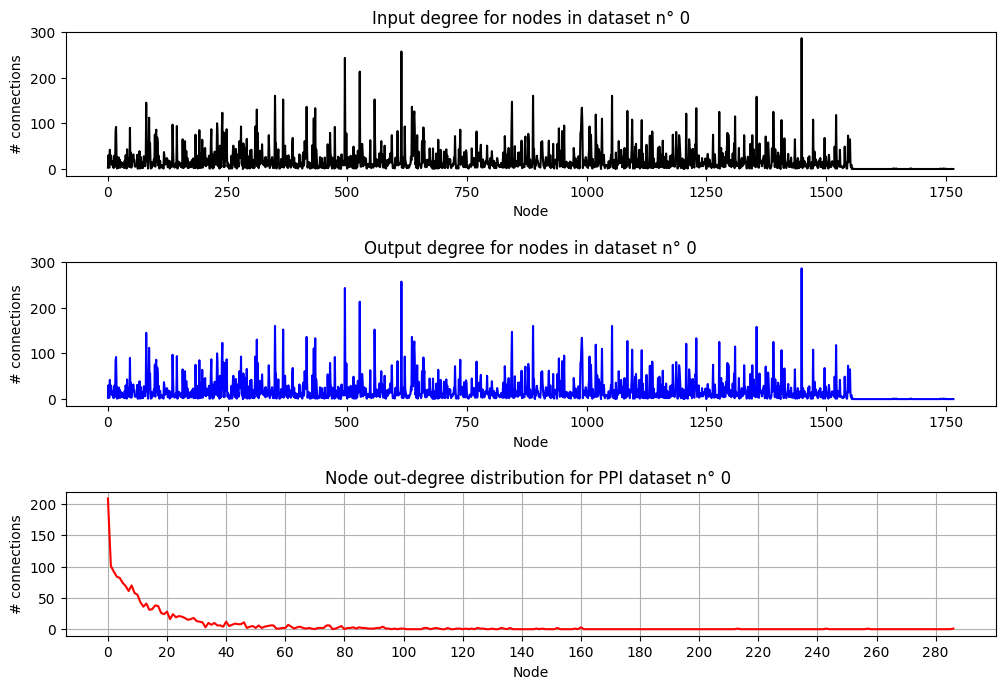

In [8]:
degree_distribution_viz(edge_index, n_nodes, DATASET_NUMBER)

**CONCLUSION**:
- Since PPI is ***undirected***, we have the same degree distribution for input and output edges
- A few number of nodes are "outliers" i.e. having a far bigger amount of edges

##### Graph

In [9]:
if isinstance(edge_index, torch.Tensor):
  edge_index_numpy = edge_index.cpu().numpy()
  
if isinstance(node_classes, torch.Tensor):
  node_classes_numpy = node_classes.cpu().numpy()

num_of_nodes = len(node_classes_numpy)
edge_index_tuples = list(zip(edge_index_numpy[0, :], edge_index_numpy[1, :]))  # igraph requires this format

# Construct the igraph graph
ig_graph = ig.Graph()
ig_graph.add_vertices(num_of_nodes)
ig_graph.add_edges(edge_index_tuples)

# Prepare the visualization settings dictionary
visual_style = {}

# Defines the size of the plot and margins
visual_style["bbox"] = (350, 350)
visual_style["margin"] = 2

edge_weights_raw = np.clip(np.log(np.asarray(ig_graph.edge_betweenness())+1e-16), a_min=0, a_max=None)
edge_weights_raw_normalized = edge_weights_raw / np.max(edge_weights_raw)
edge_weights = [w**6 for w in edge_weights_raw_normalized]
visual_style["edge_width"] = edge_weights

visual_style["vertex_size"] = [deg / 10 for deg in ig_graph.degree()]

visual_style["layout"] = ig_graph.layout_star()

print('Plotting results ...')
ig.plot(ig_graph,layout=visual_style["layout"],edge_width=visual_style['edge_width'], vertex_size=visual_style['vertex_size'] )

Plotting results ...


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-level) classification task, computing 121 features.

In [10]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):

        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next we construct the function to train the model.

In [11]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [12]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):

    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Let's train this model !

In [13]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(input_size = n_features_per_node, hidden_size = 256,output_size = node_classes.shape[1]).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(basic_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)


Device:  cuda
Epoch 00001 | Loss: 0.6368
F1-Score: 0.4558
Epoch 00002 | Loss: 0.5804
Epoch 00003 | Loss: 0.5622
Epoch 00004 | Loss: 0.5557
Epoch 00005 | Loss: 0.5508
Epoch 00006 | Loss: 0.5456
F1-Score: 0.4946
Epoch 00007 | Loss: 0.5414
Epoch 00008 | Loss: 0.5373
Epoch 00009 | Loss: 0.5340
Epoch 00010 | Loss: 0.5315
Epoch 00011 | Loss: 0.5289
F1-Score: 0.5280
Epoch 00012 | Loss: 0.5263
Epoch 00013 | Loss: 0.5239
Epoch 00014 | Loss: 0.5216
Epoch 00015 | Loss: 0.5195
Epoch 00016 | Loss: 0.5173
F1-Score: 0.5196
Epoch 00017 | Loss: 0.5151
Epoch 00018 | Loss: 0.5128
Epoch 00019 | Loss: 0.5105
Epoch 00020 | Loss: 0.5081
Epoch 00021 | Loss: 0.5058
F1-Score: 0.5236
Epoch 00022 | Loss: 0.5037
Epoch 00023 | Loss: 0.5016
Epoch 00024 | Loss: 0.4996
Epoch 00025 | Loss: 0.4976
Epoch 00026 | Loss: 0.4956
F1-Score: 0.5413
Epoch 00027 | Loss: 0.4937
Epoch 00028 | Loss: 0.4919
Epoch 00029 | Loss: 0.4901
Epoch 00030 | Loss: 0.4883
Epoch 00031 | Loss: 0.4862
F1-Score: 0.5578
Epoch 00032 | Loss: 0.4846
Ep

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the test set: 0.6591


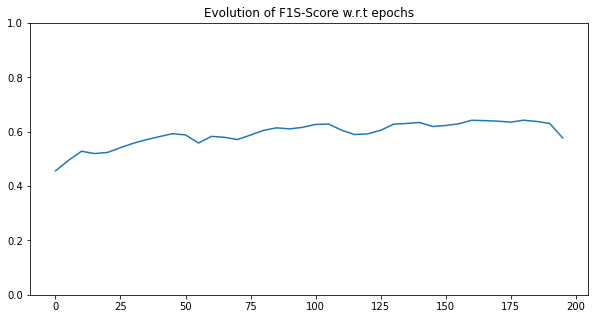

In [14]:
### F1-SCORE ON TEST DATASET
score_test = evaluate(basic_model, loss_fcn, device, test_dataloader)
print("Basic Model : F1-Score on the test set: {:.4f}".format(score_test))

### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores) :
    plt.figure(figsize=[10,5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1S-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()
    
plot_f1_score(epoch_list, basic_model_scores)

### Define a better model

Now, it's your turn to improve this basic model ! To do so, we're gonna define a **Graph Attention Network** (https://arxiv.org/pdf/1710.10903.pdf)

In [15]:
# Defines the general GAT architecture (skeleton)

class GraphAttentionNetwork(nn.Module):
    """
    Framework of the GAT module.
    Mainly takes a num of parameters that will define the inner GAT layers inside of it.

    Args:
        n_layers ():
        n_features_per_layer ():
        n_attention_heads_per_layer ():
        skip_connection (bool):
        dropout (float):
        activation (nn.Module): 
        store_attention_weights (bool):
        bias (bool): 

    Returns:
        gat_net (nn.Module):
    """

    def __init__(self, n_layers, n_features_per_layer, n_attention_heads_per_layer, skip_connection=True, dropout = 0.0, activation = nn.ELU(), store_attention_weights=False, bias = True):
        super().__init__()
        assert n_layers == len(n_attention_heads_per_layer) == len(n_features_per_layer) - 1, f'Please provide correct parameters.'
        n_attention_heads_per_layer = [1] + n_attention_heads_per_layer 

        # Instanciate list of GAT layers
        gat_layers = []

        for index in range(n_layers):
            l = Layer(
                n_input_features = n_features_per_layer[index] * n_attention_heads_per_layer[index], # Since we concatenate, the new input features number has to be Features_per_layer * N_heads
                n_output_features = n_features_per_layer[index+1], 
                n_heads = n_attention_heads_per_layer[index+1],
                concatenate = True if index < n_layers - 1 else False,  # concatenate() feature vectors of nodes on ALL layers EXCEPT for the LAST one -> avg()
                activation = activation if index < n_layers - 1 else None,  # Need to be careful not to use activation on the last layer
                dropout = dropout, #TODO: try with different values
                skip_connection = skip_connection, #TODO: try with & without
                bias = bias, #TODO: try with & without
                store_attention_weights = store_attention_weights # to plot if needed later
              )
          
            gat_layers.append(l)

        self.gat_network = nn.Sequential(*gat_layers)

    def forward(self, input):
        return self.gat_network(input)

In [16]:
# Defines a GAT Layer architecture

class Layer(nn.Module):
    """
    Layer of the GAT.
    """
    def __init__(self,
                 n_input_features,
                 n_output_features,
                 n_heads,
                 activation,
                 concatenate = True,
                 dropout = 0.0,
                 skip_connection = True,
                 non_linearity = nn.LeakyReLU,
                 bias = True,
                 store_attention_weights = False,
                 ):

        super().__init__()

        # ==================== Variables ==================== #

        self.n_output_features = n_output_features
        self.n_heads = n_heads
        self.activation = activation
        self.concatenate = concatenate
        self.skip_connection = skip_connection
        self.dropout = nn.Dropout(p=dropout)
        self.store_attention_weights = store_attention_weights
        if self.store_attention_weights:
            self.attention_weights = None # Init

        # ==================== Weights ==================== #

        # Linear Projection Matrix W

        # As per paper Graph Attention Networks (https://arxiv.org/pdf/1710.10903.pdf):
        # "In order to obtain sufficient expressive power to transform the input features into higher-level features, at least one learnable linear transformation is required.
        # "To that end, as an initial step, a shared linear transformation, parametrized by a weight matrix, W ∈ R^{F^t×F} , is applied to every node

        self.W = nn.Linear(n_input_features, n_heads * n_output_features, bias=False)

        # Attentional Matrices a

        self.a_target = nn.Parameter(torch.Tensor(1, self.n_heads, self.n_output_features))
        self.a_source = nn.Parameter(torch.Tensor(1, self.n_heads, self.n_output_features))

        # Bias b
        if bias and concatenate:
            self.bias = nn.Parameter(torch.Tensor(self.n_heads * self.n_output_features))
        if bias and not concatenate:
            self.bias = nn.Parameter(torch.Tensor(self.n_output_features))
        else:
            self.register_parameter('bias', None)

        # ==================== Additional Params ==================== #

        # Skip connection param
        # In order to retain information, we may add a skip connection layer between the GAT layers
        if skip_connection:
            self.skip_projection = nn.Linear(n_input_features, n_heads * n_output_features, bias=False)
        else:
            self.register_parameter('skip_projection', None)

        # Non Linearity (as in paper)
        if non_linearity:
            self.leakyReLU = nn.LeakyReLU(0.2)

        self.init_params()

    def forward(self, input):

        x, edge_index = input

        # 0. Retrieve number of nodes
        n_nodes = x.shape[0]

        # 1. Dropout on input
        dropped_out_x = self.dropout(x) # (n_nodes,n_input_features)

        # 2. Linear Projection
        linear_projection = self.W(dropped_out_x).view(-1, self.n_heads, self.n_output_features) # (n_nodes,n_input_features) * (n_input_features, n_heads * n_output_features) -> (n_nodes, n_heads, n_output_features)
        dropped_out_linear_projection = self.dropout(linear_projection)

        # 3. Attention scores
        attention_score_source = torch.sum(dropped_out_linear_projection * self.a_source, dim=-1) # (n_nodes, n_heads, n_output_features) * (1, n_heads, n_output_features) -> (n_nodes, n_heads)
        attention_score_target = torch.sum(dropped_out_linear_projection * self.a_target, dim=-1)
    
        # 4. Duplicates the attention scores that will be of used, based on the edge index
        attention_source_pruned, attention_target_pruned, nodes_features_proj_duplicated = self.prune(attention_score_source, attention_score_target, dropped_out_linear_projection, edge_index)
        
        # 5. Non linearity on attention scores
        scores_per_edge = self.leakyReLU(attention_source_pruned + attention_target_pruned)

        # 6. Softmaxed attention scores (alpha in paper)
        attention_softmaxed_per_edge = self.softmaxed_attention(scores_per_edge, edge_index[1], n_nodes)
        dropped_out_attention_softmaxed_per_edge = self.dropout(attention_softmaxed_per_edge)

        # 7. Aggregation of nodes in the neighborhood
        weighted_nodes_features_proj_duplicated = nodes_features_proj_duplicated * dropped_out_attention_softmaxed_per_edge

        # 8. Output (sums the weighted neighbors)
        output = self.sum_neighbors(weighted_nodes_features_proj_duplicated, edge_index, x, n_nodes)

        # 9. Additional actions (optional)
        # - skip connections
        # - concatenate
        # - bias
        output = self.additional_actions(dropped_out_attention_softmaxed_per_edge, x, output)

        return (output, edge_index)


    def prune(self,attention_score_source, attention_score_target, dropped_out_linear_projection, edge_index):
        """
        Keep only vectors that will be of used, based on the edge index
        """

        attention_score_source = attention_score_source.index_select(0, edge_index[0])
        attention_score_target = attention_score_target.index_select(0, edge_index[1])
        nodes_features_matrix_proj_duplicated = dropped_out_linear_projection.index_select(0, edge_index[0])

        return attention_score_source, attention_score_target, nodes_features_matrix_proj_duplicated

    def softmaxed_attention(self, scores_per_edge, target_index, n_nodes):
        """
        Applies softmax over the neighborhood nodes.
        """

        # ======== Substracting by max logit value to get scores_per_edge <= 0 => e^scores_per_edge <= 1
        # ==> improves stability
        scores_per_edge = scores_per_edge - scores_per_edge.max()

        # ======== Exponential (softmax)
        exp_scores_per_edge = scores_per_edge.exp()

        # ======== Sum of edges scores
        target_index_expanded = self.expand(target_index, exp_scores_per_edge)
       
        size = list(exp_scores_per_edge.shape)  # List necessary, shape = (n_nodes, n_heads)
        size[0] = n_nodes
        neighborhood_sums = torch.zeros(size, dtype=exp_scores_per_edge.dtype, device=exp_scores_per_edge.device)
        neighborhood_sums.scatter_add_(0, target_index_expanded, exp_scores_per_edge)
        sum_of_edges_scores = neighborhood_sums.index_select(0, target_index) # (n_nodes, n_heads) -> (edge_index, n_heads)

        # ======== Full attention
        attentions_per_edge = exp_scores_per_edge / (sum_of_edges_scores + 1e-16) #1e-16 avoids division by 0

        # Unsqueeze to perform element-wise * with linearly projected node features
        return attentions_per_edge.unsqueeze(-1) # (edge_index, n_heads) -> (edge_index, n_heads,1)

    def sum_neighbors(self, weighted_nodes_features_proj_pruned, edge_index, x, n_nodes):
        """
        Sums the weighted neighbors with their respective attention scores to get final output
        """

        size = list(weighted_nodes_features_proj_pruned.shape)
        size[0] = n_nodes
        output = torch.zeros(size,dtype=x.dtype, device=x.device)

        target_index_expanded = self.expand(edge_index[1], weighted_nodes_features_proj_pruned)

        output.scatter_add_(0, target_index_expanded,weighted_nodes_features_proj_pruned)

        return output

    def init_params(self):
        """
        Xavier Glorot initialization of weights.
        """

        # Init of W
        nn.init.xavier_uniform_(self.W.weight)
        nn.init.xavier_uniform_(self.a_source)
        nn.init.xavier_uniform_(self.a_target)

        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)
    
    def expand(self, to_expand, model):
        for _ in range(to_expand.dim(), model.dim()):
            to_expand = to_expand.unsqueeze(-1)

        return to_expand.expand_as(model)
    
    def additional_actions(self, dropped_out_attention_softmaxed_per_edge, x, output):
        
        # Logging of attention coeffs
        if self.store_attention_weights:
            self.attention_weights = dropped_out_attention_softmaxed_per_edge

        # Skip connection
        if self.skip_connection:
            if output.shape[-1] == x.shape[-1]:  # if input_features = output_features
                output += x.unsqueeze(1)

            else: # if input_features != output_features
                output += self.skip_projection(x).view(-1, self.n_heads, self.n_output_features)

        # Concatenate features vectors
        if self.concatenate:
            output = output.view(-1, self.n_heads * self.n_output_features) # (n_nodes, n_heads, output_features) -> (n_nodes, n_heads * output_features)
        else:
            # We use mean() 
            output = output.mean(dim=1) # (n_nodes, n_heads, output_features) -> (n_nodes, output_features)

        # Add bias
        if self.bias is not None:
            output += self.bias

        return output if self.activation is None else self.activation(output)

In [17]:
# We need to redefine the train & evaluate function to take data = (x,edge_index) for our Sequential forward method

def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            data = train_batch_device.x, train_batch_device.edge_index
            logits = model(data)[0]
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list


def evaluate(model, loss_fcn, device, dataloader):

    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        data = batch.x, batch.edge_index
        output = model(data)[0]
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Let's train your model !

In [24]:
# Architecture params

NUM_LAYERS = 3
NUM_FEATURES_PER_LAYER = [n_features_per_node, 64, 64, node_classes.shape[1]] # [50, 64, 64, 121]
SKIP_CONNECTION = True
ACTIVATION_FUNCTION = nn.ELU()
NUM_ATTENTION_HEADS_PER_LAYER = [4, 4, 6] # head * n layers
DROPOUT = 0.0
BIAS = False

# Optimizer params
lr = 0.005

student_model = GraphAttentionNetwork(
    n_layers = NUM_LAYERS,
    n_features_per_layer = NUM_FEATURES_PER_LAYER,
    n_attention_heads_per_layer = NUM_ATTENTION_HEADS_PER_LAYER,
    skip_connection = SKIP_CONNECTION,
    dropout = DROPOUT,
    activation = ACTIVATION_FUNCTION,
    store_attention_weights=False,
    bias = BIAS).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.5728
F1-Score: 0.4617
Epoch 00002 | Loss: 0.5159
Epoch 00003 | Loss: 0.4866
Epoch 00004 | Loss: 0.4659
Epoch 00005 | Loss: 0.4468
Epoch 00006 | Loss: 0.4225
F1-Score: 0.6256
Epoch 00007 | Loss: 0.3980
Epoch 00008 | Loss: 0.3830
Epoch 00009 | Loss: 0.3582
Epoch 00010 | Loss: 0.3338
Epoch 00011 | Loss: 0.3099
F1-Score: 0.7506
Epoch 00012 | Loss: 0.2874
Epoch 00013 | Loss: 0.2737
Epoch 00014 | Loss: 0.2683
Epoch 00015 | Loss: 0.2527
Epoch 00016 | Loss: 0.2517
F1-Score: 0.7898
Epoch 00017 | Loss: 0.3012
Epoch 00018 | Loss: 0.2841
Epoch 00019 | Loss: 0.2599
Epoch 00020 | Loss: 0.2399
Epoch 00021 | Loss: 0.2252
F1-Score: 0.8258
Epoch 00022 | Loss: 0.2133
Epoch 00023 | Loss: 0.2030
Epoch 00024 | Loss: 0.1941
Epoch 00025 | Loss: 0.1863
Epoch 00026 | Loss: 0.1794
F1-Score: 0.8609
Epoch 00027 | Loss: 0.1732
Epoch 00028 | Loss: 0.1678
Epoch 00029 | Loss: 0.1639
Epoch 00030 | Loss: 0.1620
Epoch 00031 | Loss: 0.1596
F1-Score: 0.8631
Epoch 00032 | Loss: 0.1624
Epoch 00033 | Los

Let's evaluate the performance of your model

Student Model : F1-Score on the test set: 0.9722


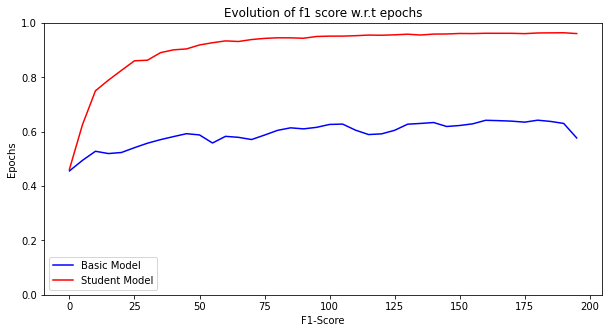

In [25]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))

def plot_f1_score(epoch_list, basic_model_scores, student_model_scores) :
    plt.figure(figsize = [10,5])
    plt.plot(epoch_list, basic_model_scores, 'b', label = "Basic Model")
    plt.plot(epoch_list, student_model_scores, 'r', label = "Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()
    
plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

### Choice of architecture

You might ask yourself "Why GAT and not GCNLayer ?".. well lookinng at the results it seems pretty clear why, but some well defined reason push for the GAT: 

1. GATs have the ability to attend to any number of neighbors using an attention mechanism to weight
the importance of each node’s neighbors during message passing.
Thus the attention mechanism allows the network to focus on the most relevant information, ignoring
noise and making it more efficient than GCNs.
1
2. GATs can adaptively adjust their receptive fields by assigning different weights to nodes and edges
based on their importance, making them more flexible and efficient in capturing local graph structures.
In contrast, GCNs have fixed receptive fields, and are not able to attend to different neighbors size; i.e.
they should redefine their kernel size for each node to be able to attend to all neighbors every time.
3. GATs share weights across nodes and layers, reducing the number of parameters, and making them
more computationally efficient both for the training part and inference.
4. GATs can handle large and complex graph structures without needing any pre-processing or feature
engineering, making them scalable and efficient.
Overall, GATs are more efficient than GCNs due to their attention mechanism, adaptive receptive fields,
parameter sharing, and scalability, hence our choice for this project

### Oversmoothing

#### What is oversmoothing ?

Oversmoothing is a challenge that GNNs can face, which causes the network’s performance to gradually
decline as the number of layers increases. This decay is due to the repeated aggregation of information from
neighboring nodes (through a message passing mechanism), which results in node embeddings that become less distinguishable from one to another.

In the most extreme case, if the GNN uses an infinite number of layers, the node embeddings will converge
to a fixed point where all nodes have the same embedding. This occurs because the repeated aggregation of
information from neighboring nodes causes the node embeddings to become increasingly similar, eventually
becoming indistinguishable from each other.

#### Are there solutions to overcome it ?
Reducing the number of layers in a GNN might seem like a straightforward solution to address over-
smoothing, but in reality, it is not that simple. To overcome this problem, a well-known technique has been
proposed in the paper ”PairNorm: Tackling over-smoothing in GNNs” [3]. The technique involves using a
new normalization layer that is based on a detailed analysis of the graph convolution operator. By preventing
node embeddings from becoming too similar, this technique effectively addresses the issue of oversmoothing
in GNNs.